This notebook provides a broad analysis of the dataset, including an examination of missing values, their potential causes, and strategies for handling them. It also covers the analysis of categorical features and how can we encode them, as well as the identification and treatment of duplicated instances, among other aspects.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [180]:
df = pd.read_parquet('../sampling/data/combined_dataset.parquet')

In [3]:
print("Nubmer of Rows : ", df.shape[0])
print("Nubmer of Columns : ", df.shape[1])

Nubmer of Rows :  1686884
Nubmer of Columns :  51


In [131]:
df.columns

Index(['id', 'message_id', 'campaign_id', 'message_type', 'client_id',
       'channel_x', 'category', 'platform', 'email_provider', 'stream', 'date',
       'sent_at', 'is_opened', 'opened_first_time_at', 'opened_last_time_at',
       'is_clicked', 'clicked_first_time_at', 'clicked_last_time_at',
       'is_unsubscribed', 'unsubscribed_at', 'is_hard_bounced',
       'hard_bounced_at', 'is_soft_bounced', 'soft_bounced_at',
       'is_complained', 'complained_at', 'is_blocked', 'blocked_at',
       'is_purchased', 'purchased_at', 'created_at', 'updated_at',
       'campaign_type', 'channel_y', 'topic', 'started_at', 'finished_at',
       'total_count', 'ab_test', 'warmup_mode', 'hour_limit', 'subject_length',
       'subject_with_personalization', 'subject_with_deadline',
       'subject_with_emoji', 'subject_with_bonuses', 'subject_with_discount',
       'subject_with_saleout', 'is_test', 'position', 'first_purchase_date'],
      dtype='object')

In [6]:
# number of features per data type
df.dtypes.value_counts()

object            24
datetime64[us]    12
bool               8
float64            4
int64              3
Name: count, dtype: int64

## Integer Features

In [8]:
df.select_dtypes(include='int').columns

Index(['id', 'campaign_id', 'client_id'], dtype='object')

In [24]:
df.select_dtypes(include='int').isnull().sum()

id             0
campaign_id    0
client_id      0
dtype: int64

In [15]:
df.shape[0] - df.id.nunique()

3918

In [17]:
df.id.duplicated().sum(), df.duplicated().sum()

(np.int64(3918), np.int64(0))

In [19]:
df.campaign_id.nunique(), df.client_id.nunique()

(1553, 40101)

In [18]:
df[['campaign_id', 'client_id']].duplicated().sum()

np.int64(87012)

## Float Features

In [20]:
df.select_dtypes(include='float').columns

Index(['total_count', 'hour_limit', 'subject_length', 'position'], dtype='object')

In [23]:
df.select_dtypes(include='float').isnull().sum().sort_values(ascending = False) / df.shape[0]

hour_limit        0.984506
position          0.949457
total_count       0.075881
subject_length    0.050545
dtype: float64

### total_count

<Axes: >

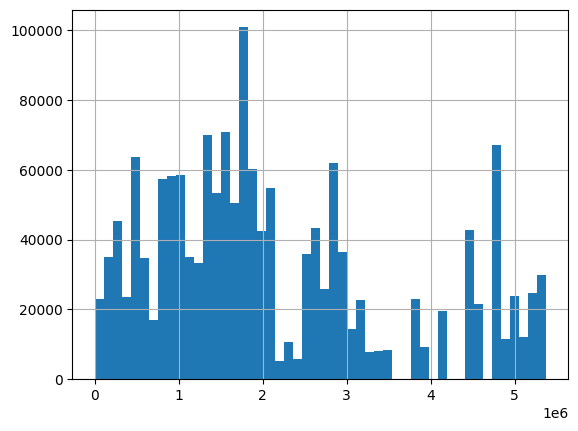

In [37]:
df['total_count'].hist(bins=50)

In [39]:
summary_stats = {
    "Minimum" : df['total_count'].min(),
    "5th Percentile": df['total_count'].quantile(0.05),
    "25th Percentile (Q1)": df['total_count'].quantile(0.25),
    "50th Percentile (Median)": df['total_count'].quantile(0.5),
    "75th Percentile (Q3)": df['total_count'].quantile(0.75),
    "95th Percentile": df['total_count'].quantile(0.95),
    "Maximum" : df['total_count'].max(),
    "Mean": df['total_count'].mean(),
    "Standard Deviation": df['total_count'].std()
}

for k, v in summary_stats.items():
    print(f"{k:25}: {v:.2f}")

Minimum                  : 3.00
5th Percentile           : 260810.00
25th Percentile (Q1)     : 1037337.00
50th Percentile (Median) : 1781536.00
75th Percentile (Q3)     : 2896782.00
95th Percentile          : 5036440.00
Maximum                  : 5371769.00
Mean                     : 2140387.30
Standard Deviation       : 1453412.74


In [33]:
df.groupby(['campaign_type'])['total_count'].sum()

campaign_type
bulk             3.336609e+12
transactional    0.000000e+00
trigger          0.000000e+00
Name: total_count, dtype: float64

In [34]:
df[df['total_count'].isnull()]['campaign_type'].value_counts()

campaign_type
trigger          85264
transactional    38347
bulk              4392
Name: count, dtype: int64

In [40]:
df[df['total_count'].isnull()]['campaign_type'].value_counts() / df.shape[0]

campaign_type
trigger          0.050545
transactional    0.022732
bulk             0.002604
Name: count, dtype: float64

'total_count' is about bulk campaigns, what was the size of the population for the specific bulk campaign, that is why it has nulls in trigger and transactional campaign types. In those instances we can impute nulls with 0, as those campaigns were not sent as batches. For nulls in bulk, it does not seem to have a natural behavior, more looks like a random errors, that is why we can impute them with the median of 'total_count' in the bulk campaigns, as 'total_count' has right skewed distribution.

### position

In [44]:
df['position'].value_counts(dropna=False) / df.shape[0]

position
NaN    0.949457
2.0    0.017870
5.0    0.007907
4.0    0.007861
3.0    0.007771
0.0    0.005776
6.0    0.001758
7.0    0.001554
9.0    0.000030
8.0    0.000017
Name: count, dtype: float64

In [45]:
df.groupby(['campaign_type'])['position'].sum()

campaign_type
bulk                  0.0
transactional         0.0
trigger          256173.0
Name: position, dtype: float64

In [50]:
df[df['campaign_type'] == 'trigger']['position'].value_counts(dropna=False)

position
2.0    30144
5.0    13338
4.0    13261
3.0    13108
0.0     9743
6.0     2965
7.0     2622
9.0       51
8.0       28
NaN        4
Name: count, dtype: int64

In [49]:
df[df['campaign_type'] != 'trigger']['position'].value_counts(dropna=False)

position
NaN    1601620
Name: count, dtype: int64

As 'position' is a discrete feature, in trigger campaign instances we can impute it with mode, while in non-trigger campaign instances we can impute it with -1 to mention them as non-applicables.

### subject_length

<Axes: >

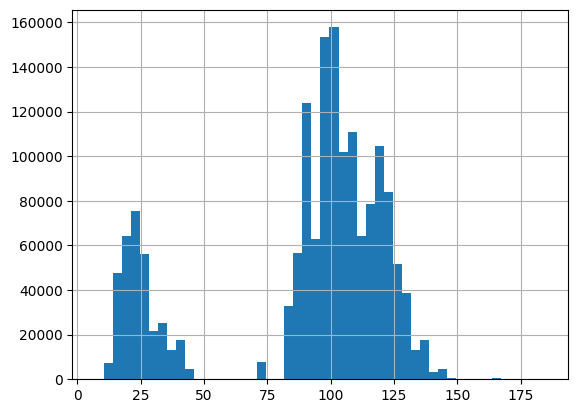

In [51]:
df['subject_length'].hist(bins=50)

In [58]:
df['subject_length'].isnull().sum()

np.int64(85264)

In [56]:
df.groupby(['campaign_type'])['subject_length'].mean()

campaign_type
bulk             89.169216
transactional    99.304926
trigger                NaN
Name: subject_length, dtype: float64

In [57]:
df[df['campaign_type'] == 'trigger']['subject_length'].value_counts(dropna=False)

subject_length
NaN    85264
Name: count, dtype: int64

In 'subject_length' nulls are only for trigger campaigns, so we can impute them as -1 to mention them as non-applicables.

### hour_limit

<Axes: >

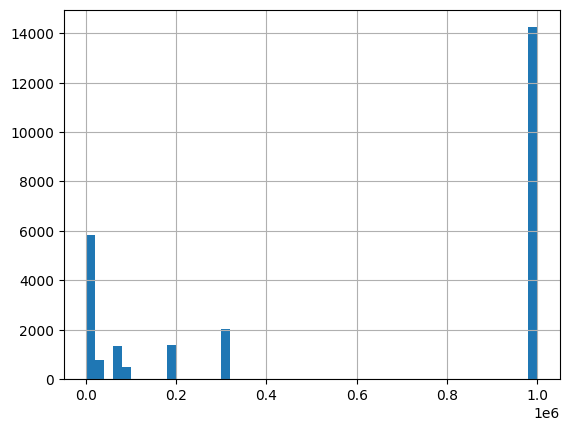

In [59]:
df['hour_limit'].hist(bins=50)

In [61]:
df['hour_limit'].value_counts(dropna=False)

hour_limit
NaN          1660748
1000000.0      14247
300500.0        2043
800.0           1835
500.0           1423
200000.0        1384
60500.0         1351
6500.0          1139
20500.0          753
100000.0         492
7500.0           413
10000.0          327
5500.0           267
10500.0          223
4000.0           206
40500.0           17
30500.0            8
50500.0            4
300.0              4
Name: count, dtype: int64

In [64]:
df[df['campaign_type'] == 'bulk']['hour_limit'].value_counts(dropna=False) / df[df['campaign_type'] == 'bulk'].shape[0]

hour_limit
NaN          0.983281
1000000.0    0.009114
300500.0     0.001307
800.0        0.001174
500.0        0.000910
200000.0     0.000885
60500.0      0.000864
6500.0       0.000729
20500.0      0.000482
100000.0     0.000315
7500.0       0.000264
10000.0      0.000209
5500.0       0.000171
10500.0      0.000143
4000.0       0.000132
40500.0      0.000011
30500.0      0.000005
50500.0      0.000003
300.0        0.000003
Name: count, dtype: float64

In [63]:
df[df['campaign_type'] != 'bulk']['hour_limit'].value_counts(dropna=False)

hour_limit
NaN    123611
Name: count, dtype: int64

Here 'hour_limit' is for bulk campaigns only, but just for a little portion of bulk campaigns, it seems that majority of the bulk campaigns do not have hour limits, so we can replace them with high numbers, while for trigger and transactional instances we can impute them with -1 for mentioning them as non-applicables.

## Bool Features

In [65]:
df.select_dtypes(include='bool').columns

Index(['is_opened', 'is_clicked', 'is_unsubscribed', 'is_hard_bounced',
       'is_soft_bounced', 'is_complained', 'is_blocked', 'is_purchased'],
      dtype='object')

In [66]:
df.select_dtypes(include='bool').isnull().sum()

is_opened          0
is_clicked         0
is_unsubscribed    0
is_hard_bounced    0
is_soft_bounced    0
is_complained      0
is_blocked         0
is_purchased       0
dtype: int64

In [69]:
for col in df.select_dtypes(include='bool').columns:
    print(f"{col} ratio : ", df[col].mean().round(5))

is_opened ratio :  0.18729
is_clicked ratio :  0.01059
is_unsubscribed ratio :  0.00239
is_hard_bounced ratio :  0.00698
is_soft_bounced ratio :  0.00227
is_complained ratio :  0.0002
is_blocked ratio :  0.00013
is_purchased ratio :  0.00037


Those features are connected to campaign outcomes.

In [71]:
df['channel_x'].unique()

array(['mobile_push', 'email', 'sms', 'web_push'], dtype=object)

In [81]:
df['is_purchased'].sum()

np.int64(616)

Although the number of purchases in the dataset is very low due to high sampling, this is not a major concern. Our research is primarily focused on open‑click engagement, which tends to decline first as customer fatigue sets in. Since purchase behavior is secondary to our analysis, having only a small quantity of purchase data does not pose a significant problem.

In [80]:
df[df['channel_x'] != 'email']['is_opened'].sum(), df[df['channel_x'] != 'email']['is_clicked'].sum(), df[df['channel_x'] != 'email']['is_purchased'].sum()


(np.int64(187257), np.int64(2673), np.int64(58))

In [79]:
df[df['channel_x'] != 'email']['is_hard_bounced'].sum()


np.int64(6736)

In [74]:
df[df['channel_x'] != 'email']['is_soft_bounced'].sum()


np.int64(0)

In [75]:
df[df['channel_x'] != 'email']['is_complained'].sum()


np.int64(0)

In [76]:
df[df['channel_x'] != 'email']['is_blocked'].sum()


np.int64(0)

In [78]:
df[df['channel_x'] != 'email']['is_unsubscribed'].sum()

np.int64(2195)

Certain features are primarily associated with the email channel, such as soft_bounce, complained, unsubscribed, and blocked. These indicators often reflect issues related to spamming practices or network delivery problems.

## Categorical Features

In [82]:
df.select_dtypes(include='object').columns

Index(['message_id', 'message_type', 'channel_x', 'category', 'platform',
       'email_provider', 'stream', 'date', 'blocked_at', 'campaign_type',
       'channel_y', 'topic', 'started_at', 'finished_at', 'ab_test',
       'warmup_mode', 'subject_with_personalization', 'subject_with_deadline',
       'subject_with_emoji', 'subject_with_bonuses', 'subject_with_discount',
       'subject_with_saleout', 'is_test', 'first_purchase_date'],
      dtype='object')

In [133]:
df.select_dtypes(include='object').isnull().sum().sort_values(ascending=False) / df.shape[0]

category                        1.000000
blocked_at                      0.999871
ab_test                         0.994700
is_test                         0.949455
platform                        0.853469
first_purchase_date             0.795017
email_provider                  0.363004
finished_at                     0.090379
started_at                      0.075881
warmup_mode                     0.073278
subject_with_personalization    0.050545
subject_with_deadline           0.050545
subject_with_emoji              0.050545
subject_with_bonuses            0.050545
subject_with_discount           0.050545
subject_with_saleout            0.050545
topic                           0.013292
date                            0.000248
campaign_type                   0.000000
channel_y                       0.000000
message_type                    0.000000
stream                          0.000000
channel_x                       0.000000
message_id                      0.000000
dtype: float64

'category' is always null, some of the features seems like binary features, in which null could be 0 or non-applicable instance.

### message_id

In [84]:
df.message_id.nunique(), df.shape[0], df.id.nunique()

(1682966, 1686884, 1682966)

In [88]:
df.message_id.duplicated().sum(), df.id.duplicated().sum()

(np.int64(3918), np.int64(3918))

In [89]:
df[['message_id', 'id']].head()

,message_id,id
0,1515915625489087633-11387-64244e6bd4d4e,689791327
1,1515915625489107288-11387-64244e6bd72d3,689792401
2,1515915625489112445-11387-64244e6bd81d6,689792664
3,1515915625489122538-11387-64244e6bd98c2,689793297
4,1515915625489133634-11387-64244e6bdb2a6,689793902


message_id and id illustrate the same things, they are unique for each message, and they have same count of duplicated values.

### message_type & campaign_type

In [90]:
df['message_type'].value_counts()

message_type
bulk             1565223
trigger            85264
transactional      36397
Name: count, dtype: int64

After the feature engineering we will remain just bulk and trigger campaigns from here as one-hot encoded features, as transactional messages does not seems relevant for our analysis.

In [91]:
df['campaign_type'].value_counts()

campaign_type
bulk             1563273
trigger            85264
transactional      38347
Name: count, dtype: int64

In [94]:
(df['campaign_type'] != df['message_type']).sum()

np.int64(3918)

In [95]:
df[df['campaign_type'] != df['message_type']][['campaign_type','message_type']]

,campaign_type,message_type
5627,bulk,transactional
5679,bulk,transactional
5682,bulk,transactional
5787,bulk,transactional
5789,bulk,transactional
...,...,...
1252164,transactional,bulk
1252166,transactional,bulk
1252168,transactional,bulk
1252170,transactional,bulk


In [112]:
(df[df['campaign_type'] != df['message_type']][['campaign_type','message_type']]['campaign_type'].unique(),
 df[df['campaign_type'] != df['message_type']][['campaign_type','message_type']]['message_type'].unique())

(array(['bulk', 'transactional'], dtype=object),
 array(['transactional', 'bulk'], dtype=object))

The number of missmatches are the same as the number of duplicates in id column, therefore it seems that the same id is assigned to different kind of campaigns (bulk and transactional).

In [121]:
(df[df['campaign_type'] != df['message_type']]\
    ['is_opened'].mean(),
df[df['campaign_type'] != df['message_type']]\
    ['is_clicked'].mean(),
df['is_opened'].mean(),
df['is_clicked'].mean()
)

(np.float64(0.23736600306278713),
 np.float64(0.005359877488514548),
 np.float64(0.1872938506737867),
 np.float64(0.010590532603308823))

### channel_x and channel_y

In [100]:
df['channel_x'].value_counts(), df['channel_y'].value_counts()

(channel_x
 email          1074855
 mobile_push     611678
 web_push           347
 sms                  4
 Name: count, dtype: int64,
 channel_y
 email           1004027
 mobile_push      597589
 multichannel      85264
 sms                   4
 Name: count, dtype: int64)

channel_y is a more high level labeling of channel types, based on for which channels the campaign was created, while channel_x is the specific channel, which was used for a specific communication. That is why nn our Analysis we will use 'channel_x'.

In [108]:
df[df['channel_x'] != df['channel_y']].groupby(['channel_x', 'channel_y'])['id'].count().reset_index()

,channel_x,channel_y,id
0,email,mobile_push,426
1,email,multichannel,73655
2,mobile_push,email,3253
3,mobile_push,multichannel,11262
4,web_push,multichannel,347


In [118]:
df[(df['channel_x'] != df['channel_y']) & (df['channel_y'] != 'multichannel')
    & (df['campaign_type'] != df['message_type'])].shape[0]
    

3679

Those 3679 instances, in which channel_x and channel_y are different, while channel_y is not multichannel is also caused by duplicates in ids.

### Id Duplicates Analysis

In [125]:
messages_df = pd.read_parquet('../sampling/data/messages_subset.parquet')

In [128]:
messages_df['id'].duplicated().sum()

np.int64(0)

In [129]:
campaign_df = pd.read_csv('../sampling/data/campaigns.csv')

campaign_df['id'].duplicated().sum()

np.int64(7)

In [139]:
campaign_df[campaign_df['id'].isin(campaign_df['id'][campaign_df['id'].duplicated()])].sort_values(by = 'id')

,id,campaign_type,channel,topic,started_at,finished_at,total_count,ab_test,warmup_mode,hour_limit,subject_length,subject_with_personalization,subject_with_deadline,subject_with_emoji,subject_with_bonuses,subject_with_discount,subject_with_saleout,is_test,position
1,64,bulk,mobile_push,sale out,2021-04-30 09:02:50.817227,2021-04-30 09:04:08,1037337.0,NaN,False,NaN,97.0,False,False,True,False,False,False,NaN,NaN
1867,64,transactional,email,order ready for pickup,NaN,NaN,NaN,NaN,NaN,NaN,139.0,False,False,False,False,False,False,NaN,NaN
34,366,bulk,email,sale out,2021-06-10 08:28:34.471796,2021-06-10 10:19:05,160689.0,NaN,False,NaN,85.0,False,False,True,False,False,False,NaN,NaN
1860,366,transactional,mobile_push,order reminder,NaN,NaN,NaN,NaN,NaN,NaN,125.0,False,False,False,False,False,False,NaN,NaN
35,368,bulk,mobile_push,sale out,2021-06-11 10:00:11.717483,2021-06-11 10:00:22,16027.0,NaN,False,NaN,117.0,False,False,True,False,False,False,NaN,NaN
1881,368,transactional,mobile_push,order created,NaN,NaN,NaN,NaN,NaN,NaN,111.0,False,False,False,False,False,False,NaN,NaN
36,372,bulk,mobile_push,sale out,2021-06-10 13:00:10.520899,2021-06-10 13:00:21,24425.0,NaN,False,NaN,119.0,False,False,True,False,True,False,NaN,NaN
1889,372,transactional,mobile_push,order created,NaN,NaN,NaN,NaN,NaN,NaN,111.0,False,False,False,False,False,False,NaN,NaN
37,373,bulk,mobile_push,sale out,2021-06-11 14:00:11.427774,2021-06-14 06:00:54,2532.0,NaN,False,NaN,111.0,False,False,True,False,False,False,NaN,NaN
1890,373,transactional,mobile_push,order shipped,NaN,NaN,NaN,NaN,NaN,NaN,138.0,False,False,False,False,False,False,NaN,NaN


In [134]:
client_first_purchase_df = pd.read_csv('../sampling/data/client_first_purchase_date.csv')

In [136]:
client_first_purchase_df.client_id.duplicated().sum()

np.int64(0)

The duplicates in campaign IDs appear to be caused by errors during data entry, particularly in cases where bulk campaigns were registered alongside their associated transactional campaigns, resulting in shared IDs. In some instances, campaigns were simultaneously linked to both email and push channels, which explains the mismatches observed between channel features and campaign type features in the dataset. Since it is unclear which duplicate instance is correct—or whether both are valid—and the overall volume of duplicates is minimal (approximately 0.2%), we will retain the features as they are. However, to avoid redundancy, we will drop the channel_y and campaign_type columns and instead rely on message_type and channel_x.

### platform, email provider and stream

In [141]:
df['platform'].value_counts(dropna=False) / df.shape[0]

platform
None          0.853469
android       0.107416
desktop       0.031232
smartphone    0.007146
phablet       0.000496
tablet        0.000241
Name: count, dtype: float64

As proportion of the missing values is so high, we can simply make one-hot encoded variable for that.

In [142]:
df['email_provider'].value_counts(dropna=False) / df.shape[0]

email_provider
None           3.630042e-01
mail.ru        3.227940e-01
gmail.com      1.404193e-01
yandex.ru      9.549323e-02
bk.ru          2.504144e-02
                   ...     
nextmail.ru    5.928090e-07
onego.ru       5.928090e-07
is74.ru        5.928090e-07
ymail.ru       5.928090e-07
front.ru       5.928090e-07
Name: count, Length: 104, dtype: float64

In [143]:
df['email_provider'].isnull().sum()

np.int64(612346)

In [144]:
df[df['channel_x'] != 'email']['email_provider'].isnull().sum()

np.int64(612025)

In [145]:
612346 - 612025

321

Just 321 instances exist where the channel of the communication was email, but the email provider is null, it also can be because of duplicates in the campaigns dataset.
As it is just a slight number we can simply use null values as another category in our one-hot/target encoding.

Simply we can combine into one group everything except the three major email providers, and we will have 3 major groups, 1 group for nulls and 1 group for every other providers.

In [156]:
df['stream'].value_counts(dropna=False)

stream
desktop    1657571
android      29119
ios            194
Name: count, dtype: int64

Here ios and android can be simply combined, as ios has just a few instances and can cause high variance in the prediction.

### ab_test, is_test and warmup_mode

In [150]:
df['ab_test'].value_counts(dropna=False) / df.shape[0]

ab_test
None    0.9947
True    0.0053
Name: count, dtype: float64

As there is no false, just True and nulls, we can assume that nulls are false.

In [149]:
df['is_test'].value_counts(dropna=False) / df.shape[0]

is_test
None     0.949455
False    0.050545
Name: count, dtype: float64

In [172]:
(df[df['is_test'].isnull()]['is_opened'].mean(),
df[df['is_test'] == False]['is_opened'].mean()
)

(np.float64(0.18337995279779223), np.float64(0.2608134734471758))

This flag usually indicates that the campaign or communication was a test send — for internal QA or developer validation — not part of the real customer-facing campaign.

So:
Value	Meaning

True ---- The record belongs to a test campaign (for internal validation, or maybe test audience).

False ---- The record belongs to a real (production) campaign.

Null ---- The platform didn’t explicitly log the field — often meaning “not relevant / not applicable” (e.g., older campaigns or systems that didn’t record this flag).

It appears that our dataset does not contain any explicit tests, though the meaning of the null values remains unclear. While these null cases show noticeably different open rates, this variation may simply reflect general fluctuations in the data. Since the interpretation of is_test == null is uncertain, we prefer to exclude this feature from our analysis. Our objective is not only to build accurate predictions, but more importantly to understand the underlying reasons behind changes in customer engagement behavior.

In [151]:
df['warmup_mode'].value_counts(dropna=False) / df.shape[0]

warmup_mode
False    0.911229
None     0.073278
True     0.015494
Name: count, dtype: float64

Here missing values can be just unknowns, not False values, but as the majority of warmup_mode is false, we can assume them as false, or consider them as other category.

### blocked_at

In [161]:
df['blocked_at'].value_counts(dropna=False).head()

blocked_at
None                   1686666
2022-08-22 14:59:19          2
2022-10-30 09:45:12          2
2022-06-30 07:11:13          2
2022-11-04 16:05:05          2
Name: count, dtype: int64

In [164]:
df[df['is_blocked'] != 1]['blocked_at'].value_counts(dropna=False)

blocked_at
None    1686666
Name: count, dtype: int64

In [165]:
df[df['is_blocked'] == 1]['blocked_at'].value_counts(dropna=False)

blocked_at
2022-11-04 16:05:05    2
2022-08-22 14:59:19    2
2022-06-30 07:11:13    2
2022-10-30 09:45:12    2
2022-07-07 10:55:20    1
                      ..
2022-10-29 06:05:47    1
2022-10-29 06:05:34    1
2022-11-05 06:50:09    1
2022-11-05 12:25:08    1
2022-06-30 06:59:44    1
Name: count, Length: 214, dtype: int64

blocked_at is when the block happened, so it is null if is_blocked is false. As we have engineered is_blocked window rate features in src.feature_engineering.py, we do not need this information anymore.

### started_at & finished_at

In [167]:
df['started_at'].value_counts(dropna=False).head()

started_at
None                          128003
2021-11-24 07:03:20.136238     14247
2022-06-15 06:30:07.193285     12723
2022-12-30 07:00:11.673070     12486
2022-01-03 07:00:11.774563     12278
Name: count, dtype: int64

In [168]:
df['finished_at'].value_counts(dropna=False).head()

finished_at
None                   152459
2021-11-24 14:31:56     14247
2022-06-15 09:38:54     12723
2022-12-30 10:54:27     12486
2022-01-03 11:19:05     12278
Name: count, dtype: int64

In [173]:
(df['started_at'].isnull().sum() / df.shape[0], 
df['finished_at'].isnull().sum() / df.shape[0])

(np.float64(0.07588132912517992), np.float64(0.09037906578045675))

In [ ]:
df['started_at'] = pd.to_datetime(df['started_at'])
df['finished_at'] = pd.to_datetime(df['finished_at'])

In [196]:
df_dates = df.drop_duplicates(subset=['started_at', 'finished_at'])

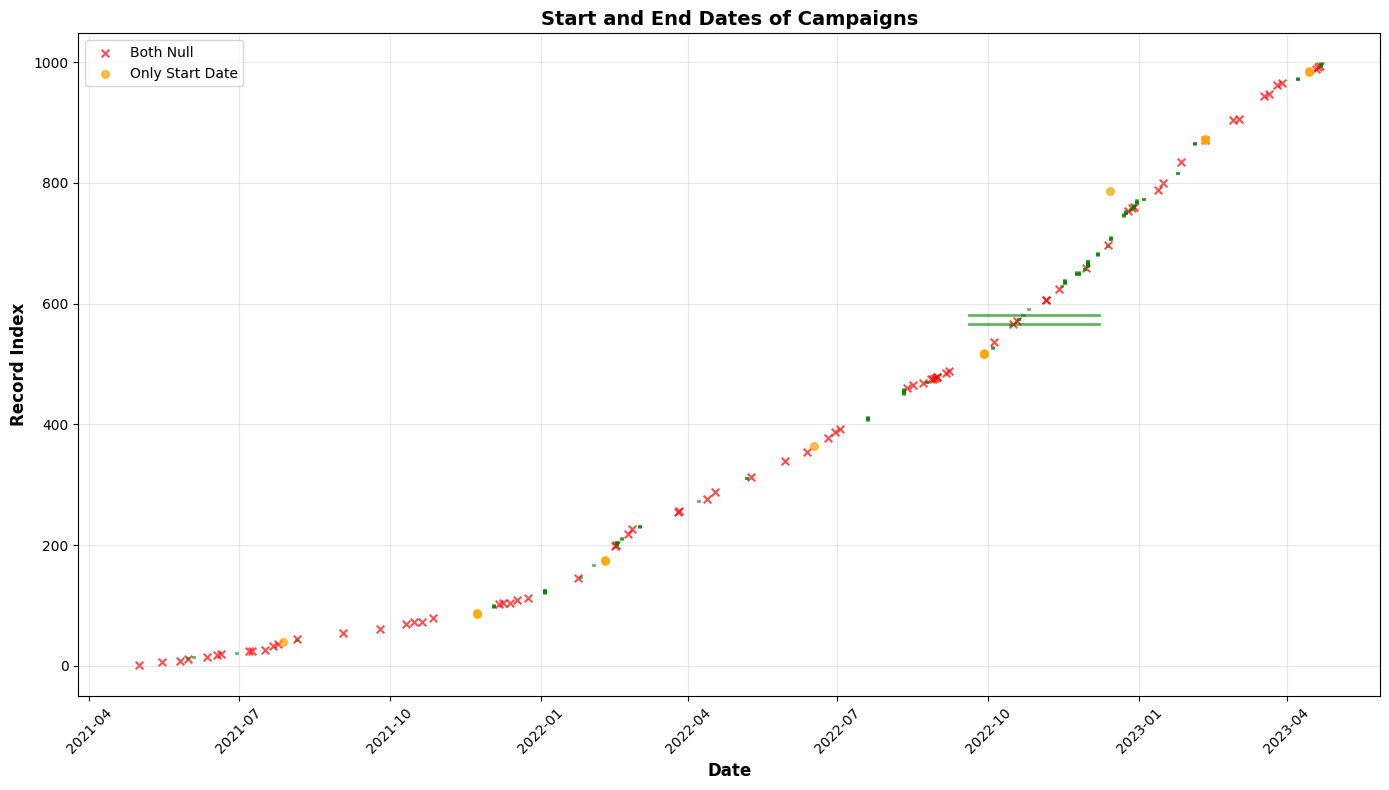

In [201]:
def plot_date_timeline_with_nulls(df, start_col='started_at', end_col='finished_at', 
                                   sample_size=1000, title=None):
    """
    Plot timeline showing relationship between start and end dates with null indicators.
    
    Parameters
    ----------
    df : pd.DataFrame
        Dataframe with date columns
    start_col : str
        Name of start date column
    end_col : str
        Name of end date column
    sample_size : int
        Number of records to plot (for performance)
    title : str, optional
        Custom title for the plot
    """
    
    # Sample for performance
    df_sample = df.sample(min(sample_size, len(df)), random_state=42).copy()
    df_sample = df_sample.sort_values('sent_at')
    df_sample['index'] = range(len(df_sample))
    
    # Classify records
    df_sample['status'] = 'Both Available'
    df_sample.loc[df_sample[start_col].isna() & df_sample[end_col].notna(), 'status'] = 'Only End Date'
    df_sample.loc[df_sample[start_col].notna() & df_sample[end_col].isna(), 'status'] = 'Only Start Date'
    df_sample.loc[df_sample[start_col].isna() & df_sample[end_col].isna(), 'status'] = 'Both Null'
    
    # Create plot
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Color mapping
    colors = {
        'Both Available': 'green',
        'Only Start Date': 'orange',
        'Only End Date': 'blue',
        'Both Null': 'red'
    }
    
    for status in df_sample['status'].unique():
        mask = df_sample['status'] == status
        subset = df_sample[mask]
        
        if status == 'Both Available':
            # Draw lines from start to end
            for _, row in subset.iterrows():
                ax.plot([row[start_col], row[end_col]], 
                       [row['index'], row['index']], 
                       color=colors[status], alpha=0.6, linewidth=2)
        elif status == 'Only Start Date':
            # Draw points for start dates
            ax.scatter(subset[start_col], subset['index'], 
                      color=colors[status], alpha=0.7, s=30, label=status)
        elif status == 'Only End Date':
            # Draw points for end dates
            ax.scatter(subset[end_col], subset['index'], 
                      color=colors[status], alpha=0.7, s=30, label=status)
        else:  # Both Null
            # Draw markers at sent_at
            ax.scatter(subset['sent_at'], subset['index'], 
                      color=colors[status], alpha=0.7, s=30, marker='x', label=status)
    
    ax.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax.set_ylabel('Record Index', fontsize=12, fontweight='bold')
    ax.set_title(title or f'Timeline: {start_col} vs {end_col}', 
                fontsize=14, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return fig

# Usage
fig = plot_date_timeline_with_nulls(
    df, 
    start_col='started_at', 
    end_col='finished_at',
    sample_size=1000,
    title='Start and End Dates of Campaigns'
)

plt.show()

In [202]:
(df_dates[df_dates['started_at'].isnull() & df_dates['finished_at'].isnull()].shape[0],
df_dates[df_dates['started_at'].isnull() & df_dates['finished_at'].notnull()].shape[0],
df_dates[df_dates['started_at'].notnull() & df_dates['finished_at'].isnull()].shape[0],
df_dates[df_dates['started_at'].notnull() & df_dates['finished_at'].notnull()].shape[0]
)

(1, 0, 16, 1484)

On the x‑axis, the sent_at feature represents the time when each message was delivered to a client. There is only one case in which both started_at and finished_at are null. The chart shows that this campaign was active throughout the entire two‑year period, which suggests it likely began before the earliest date in our dataset and ended after the latest date. This explains why both features are null.

Additionally, there are 16 types of campaigns that started within our observation window but finished afterward. These appear as several orange dots on the chart, particularly concentrated in the final months of the time interval.

Overall, the presence of nulls in these features seems logical and does not indicate any technical issues. Since we have already engineered campaign‑level and company‑level features (such as the number of messages sent in previous time windows and their engagement metrics), the started_at and finished_at features can be safely dropped from further analysis.

### first_purchase_date

In [204]:
df['first_purchase_date'].notnull().sum()

np.int64(345783)

In [206]:
df['first_purchase_date'].value_counts(dropna=False).head()

first_purchase_date
None          1341101
2022-04-09       3565
2021-12-15       3443
2022-04-15       3375
2022-04-08       2643
Name: count, dtype: int64

In [207]:
df['first_purchase_date'] = pd.to_datetime(df['first_purchase_date'])

In [208]:
df['first_purchase_date'].min()

Timestamp('2021-12-15 00:00:00')

In [209]:
df['first_purchase_date'].max()

Timestamp('2023-12-12 00:00:00')

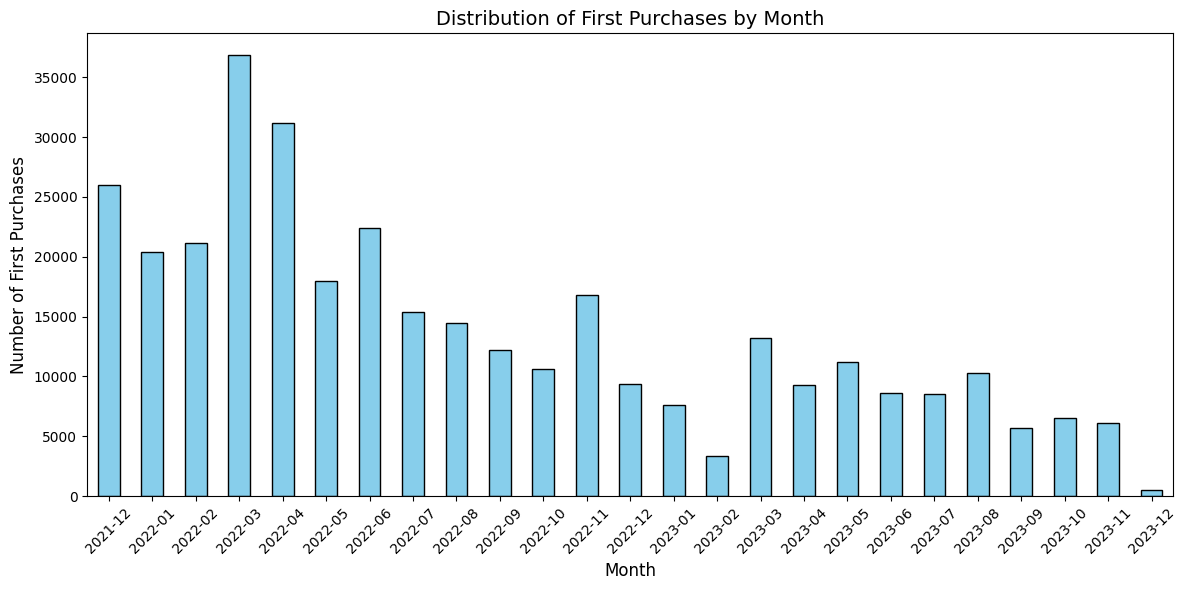

In [211]:
# Extract year-month
monthly_counts = df['first_purchase_date'].dt.to_period('M')\
                                        .value_counts().sort_index()

plt.figure(figsize=(12,6))
monthly_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title("Distribution of First Purchases by Month", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of First Purchases", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This feature simply captures the month of each client’s first purchase. Within our observation window, the coverage is slightly uneven: for 2023 it spans almost the entire year except April, while for 2021 it begins in December rather than April. 

As a result, the feature does not allow us to identify very old customers. Since we have already engineered more comprehensive purchase behavior features, this feature adds little analytical value and can be safely dropped.

### date and sent_at

In [213]:
df['date'].head(1)

0    2023-03-29
Name: date, dtype: object

In [219]:
(df['sent_at'].dt.strftime('%Y-%m-%d') == df['date'].astype(str).str.strip()).sum()

np.int64(1686465)

In [220]:
df['date'].count()

np.int64(1686465)

In [221]:
df[['sent_at', 'date']].head()


,sent_at,date
0,2023-03-29 14:51:41,2023-03-29
1,2023-03-29 14:51:46,2023-03-29
2,2023-03-29 14:51:48,2023-03-29
3,2023-03-29 14:51:50,2023-03-29
4,2023-03-29 14:51:54,2023-03-29


sent_at and date just illustrates the time when a message was sent to a client. sent_at is a timestemp, while date illustrates just year, month and day.



In [222]:
df['date'].isnull().sum(), df['sent_at'].isnull().sum()

(np.int64(419), np.int64(419))

In [224]:
(df[df['date'].isnull()]['is_opened'].mean(), 
df[df['date'].isnull()]['is_clicked'].mean(),
df[df['date'].isnull()]['is_purchased'].mean()
)

(np.float64(0.8520286396181385),
 np.float64(0.09069212410501193),
 np.float64(0.0))

In [227]:
(
    (df[df['date'].isnull()]['is_opened'].mean() - df['is_opened'].mean()) / df['is_opened'].mean(), 
df[df['date'].isnull()]['is_clicked'].mean() - df['is_clicked'].mean() / df['is_clicked'].mean(),
df[df['date'].isnull()]['is_purchased'].mean() - df['is_purchased'].mean() / df['is_purchased'].mean()
)

(np.float64(3.549154371875952),
 np.float64(-0.9093078758949881),
 np.float64(-1.0))

In [251]:
df[(df['date'].isnull())]['message_type'].value_counts()

message_type
bulk             261
trigger          128
transactional     30
Name: count, dtype: int64

In [228]:
# to detect if the nulls were in the original file
messages_df['sent_at'].isnull().sum()

np.int64(419)

Since the original data already contains nulls, it is not logical for these features to have additional null values, which we assume are caused by technical reasons. Although this sample shows a high deviation from the average open, click, and purchase rates, it consists of only 419 messages. Given that confidence in the sent_at timestamp is essential for constructing lag and window features in our analysis, we will simply drop these nulls.

In [248]:
df[['sent_at', 'client_id']].duplicated().sum()

np.int64(6469)

In [249]:
df[df[['sent_at', 'client_id']].duplicated()].head()

,id,message_id,campaign_id,message_type,client_id,channel_x,category,platform,email_provider,stream,...,subject_with_personalization,subject_with_deadline,subject_with_emoji,subject_with_bonuses,subject_with_discount,subject_with_saleout,is_test,position,first_purchase_date,missing_type
5338,3641814,83882384-ed41-4a0d-93f7-b9fc926a6d7c,27,transactional,1515915625472576541,email,None,None,mail.ru,desktop,...,False,False,False,False,False,False,None,NaN,2022-01-30,Start missing
5346,3642885,dd395809-8548-4b98-a64d-8eb7e0217771,27,transactional,1515915625505397921,email,None,None,gmail.com,desktop,...,False,False,False,False,False,False,None,NaN,NaT,Start missing
5559,4559402,fdfa0dc0-f11a-4549-9e80-462d7b0f7650,29,transactional,1515915625536041882,email,None,None,gmail.com,desktop,...,False,False,False,False,False,False,None,NaN,2022-10-31,Start missing
5593,4989617,9d56e75d-19b4-41df-911a-4d227a0fb7cb,358,transactional,1515915625590050373,mobile_push,None,None,None,desktop,...,False,False,False,False,False,False,None,NaN,NaT,Start missing
5594,4989625,9f29dd1b-3d4c-4c5f-b0f8-6f29f4310838,358,transactional,1515915625672809370,mobile_push,None,None,None,desktop,...,False,False,False,False,False,False,None,NaN,NaT,Start missing


In [252]:
df[df[['sent_at', 'client_id']].duplicated()]['message_type'].value_counts()

message_type
transactional    3152
bulk             2958
trigger           359
Name: count, dtype: int64

In [253]:
messages_df[['sent_at', 'client_id']].duplicated().sum()

np.int64(2551)

In [254]:
messages_df[messages_df[['sent_at', 'client_id']].duplicated()]['message_type'].value_counts()

message_type
transactional    2168
trigger           359
bulk               24
Name: count, dtype: int64

It appears that duplicates in the sent_at–client_id pairs are primarily caused by duplicate entries in the campaigns dataset. In addition, the original messages dataset shows some cases where multiple messages were sent simultaneously. Most of these are transactional in nature, which can be explained by customers performing multiple transactions at the same time, resulting in concurrent message sends.

### topic

In [268]:
df['topic'].value_counts(dropna=False)

topic
sale out                      1529081
abandoned view                  30144
None                            22422
recent purchase                 13338
abandoned cart                  13261
abandoned category              13108
order ready for pickup          11090
order created                   10128
subscribed                       9743
welcome campaign                 7839
order reminder                   6309
order cancelled                  6062
added to wish list               2965
abandoned search                 2622
happy birthday                   1888
welcome letter                   1726
profile updated                  1423
offer after purchase             1389
order pickup still pending       1020
event                             522
bonuses expired                   386
order shipped                     181
leave review                      154
price drop                         79
back in stock                       4
Name: count, dtype: int64

Here we can use target encoding and encode missing values as another category.

## Datetime Features

In [230]:
df.select_dtypes(include='datetime').columns

Index(['sent_at', 'opened_first_time_at', 'opened_last_time_at',
       'clicked_first_time_at', 'clicked_last_time_at', 'unsubscribed_at',
       'hard_bounced_at', 'soft_bounced_at', 'complained_at', 'purchased_at',
       'created_at', 'updated_at', 'started_at', 'finished_at',
       'first_purchase_date'],
      dtype='object')

sent_at, first_purchase_date, started_at and finished_at features we have already covered in the previous section.

In [234]:
(df.select_dtypes(include='datetime').isnull().sum() / df.shape[0]).sort_values(ascending=False)

complained_at            0.999799
purchased_at             0.999635
soft_bounced_at          0.997728
unsubscribed_at          0.997607
hard_bounced_at          0.993023
clicked_first_time_at    0.989409
clicked_last_time_at     0.989409
opened_first_time_at     0.812706
opened_last_time_at      0.812706
first_purchase_date      0.795017
finished_at              0.090379
started_at               0.075881
sent_at                  0.000248
created_at               0.000000
updated_at               0.000000
dtype: float64

'opened_first_time_at', 'opened_last_time_at',
'clicked_first_time_at', 'clicked_last_time_at', 'unsubscribed_at',
'hard_bounced_at', 'soft_bounced_at', 'complained_at', 'purchased_at'

Those features have the same kind of relationships to their binary features, as blocked_at had to is_block feature.
Therefore it seems logical to have high concentration of nulls there.

### created_at & updated_at

In [239]:
print("created_at", (df['created_at'].min(), df['created_at'].max()))
print("updated_at", (df['updated_at'].min(), df['updated_at'].max()))

created_at (Timestamp('2023-04-27 08:54:57.536995'), Timestamp('2023-05-18 01:54:48.440743'))
updated_at (Timestamp('2023-04-27 08:54:57.537578'), Timestamp('2023-05-18 01:54:55.310972'))


In [241]:
df[['created_at', 'updated_at']].head()

,created_at,updated_at
0,2023-05-17 08:12:14.569302,2023-05-17 08:12:14.570258
1,2023-05-17 08:12:19.550044,2023-05-17 08:12:19.553334
2,2023-05-17 08:12:20.833680,2023-05-17 08:12:20.834872
3,2023-05-17 08:12:24.138885,2023-05-17 08:12:24.140393
4,2023-05-17 08:12:26.291908,2023-05-17 08:12:26.292898


These features appear to represent the time when records were saved in the database. Since their dates occur after the latest sent_at timestamp, they do not provide meaningful information about message delivery or engagement. Therefore, we consider these features uninformative for our analysis.

### Messages Sent After Unsubscription

In [242]:
df['unsubscribed_at']

0         NaT
1         NaT
2         NaT
3         NaT
4         NaT
           ..
1686879   NaT
1686880   NaT
1686881   NaT
1686882   NaT
1686883   NaT
Name: unsubscribed_at, Length: 1686884, dtype: datetime64[us]

In [264]:
# Flag messages sent after unsubscription
client_engagement = (
    df.assign(sent_after_unsub=(df['unsubscribed_at'].notna()) & (df['sent_at'] > df['unsubscribed_at']))
      .groupby(['client_id','sent_after_unsub'])[['is_opened','is_clicked','is_purchased']]
      .mean()
      .reset_index()
)

In [265]:
client_engagement['sent_after_unsub'].value_counts()

sent_after_unsub
False    40101
Name: count, dtype: int64

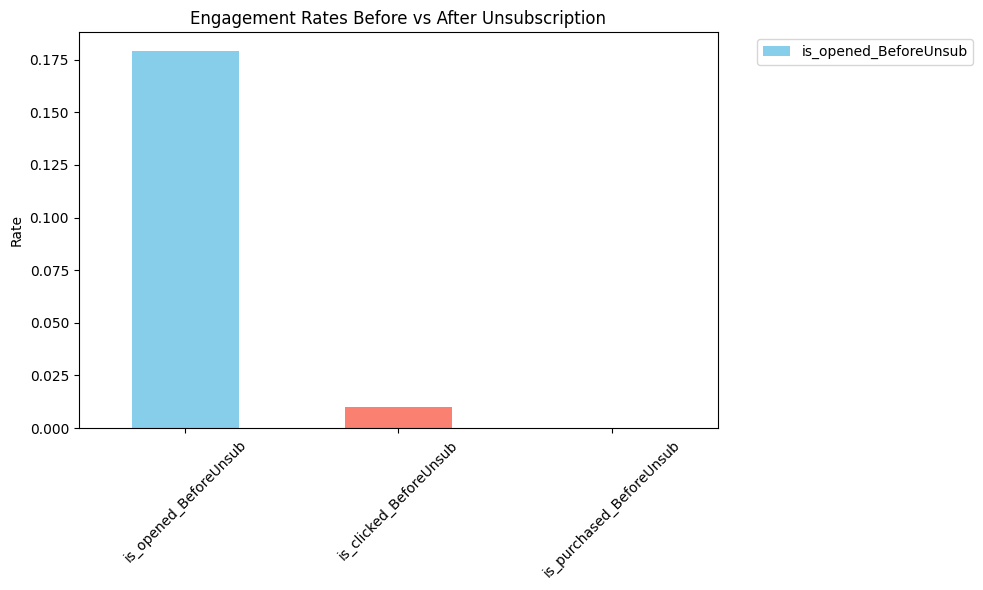

In [267]:
# Pivot so each client has two columns: before and after
pivoted = client_engagement.pivot(index='client_id', 
                                  columns='sent_after_unsub', 
                                  values=['is_opened','is_clicked','is_purchased'])

# Rename columns for clarity
pivoted.columns = [f"{metric}_{'AfterUnsub' if after else 'BeforeUnsub'}"
                   for metric, after in pivoted.columns]

# Example: plot average engagement rates across all clients
pivoted.mean().plot(kind='bar', figsize=(10,6), color=['skyblue','salmon','skyblue','salmon','skyblue','salmon'])

plt.title("Engagement Rates Before vs After Unsubscription")
plt.ylabel("Rate")
plt.xticks(rotation=45)
plt.legend(pivoted.mean().index, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

On the one hand, unsubscription means the end of communication, which seems logical, while, on the other hand, it seems that none of the customers who unsubscribed, were recovered after that.